In [ ]:
! mkdir ~/.kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download hojjatk/mnist-dataset

Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
 95% 21.0M/22.0M [00:01<00:00, 31.9MB/s]
100% 22.0M/22.0M [00:01<00:00, 20.1MB/s]


In [ ]:
!unzip /content/mnist-dataset.zip -d /content/dataset

Archive:  /content/mnist-dataset.zip
  inflating: /content/dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: /content/dataset/t10k-images.idx3-ubyte  
  inflating: /content/dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: /content/dataset/t10k-labels.idx1-ubyte  
  inflating: /content/dataset/train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: /content/dataset/train-images.idx3-ubyte  
  inflating: /content/dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: /content/dataset/train-labels.idx1-ubyte  


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [ ]:
!pip install idx2numpy


  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=cee9d43e92f5b40a6fe0fa4d378706da9f6e7aa5d4df0da9dfa2c34479bb224c
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


In [ ]:
import idx2numpy

# Paths to your IDX files
test_images_path = '/content/dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
train_images_path = '/content/dataset/train-images-idx3-ubyte/train-images-idx3-ubyte'
train_labels_path = '/content/dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_labels_path = '/content/dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

# Load the IDX files into NumPy arrays

# Load data into NumPy arrays
train_images = idx2numpy.convert_from_file(train_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_images = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)


In [ ]:
print(f"test Images shape: {test_images.shape}")  # Expected: (num_samples, 28, 28) for MNIST
print(f"train images shape: {train_images.shape}")  # Expected: (num_samples,)

test Images shape: (10000, 28, 28)
train images shape: (60000, 28, 28)


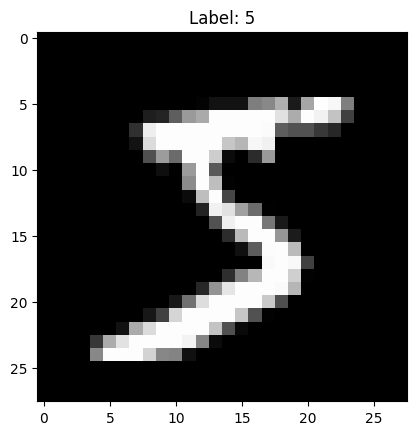

In [ ]:
# Display a sample image and label
import matplotlib.pyplot as plt

plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()

In [ ]:
# Normaliser les images pour les adapter à Faster R-CNN
def normalize_images(images):
    return images / 255.0

In [ ]:
train_images = normalize_images(train_images)
test_images = normalize_images(test_images)

In [ ]:
# Définir un Dataset pour MNIST avec bounding boxes fictives
class MNISTFasterRCNNDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Simuler une bounding box autour du chiffre
        boxes = torch.tensor([[5, 5, 23, 23]], dtype=torch.float32)  # Ex.: box centrale pour 28x28
        labels = torch.tensor([label], dtype=torch.int64)

        # Convertir en format compatible avec Faster R-CNN
        target = {"boxes": boxes, "labels": labels}

        # Convertir l'image au format tensor
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Ajouter canal

        return image, target

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Normalize and convert images to float tensors
test_images_tensor = torch.tensor(test_images / 255.0, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
train_images_tensor = torch.tensor(train_images / 255.0, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

        # Dropout
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")


Epoch [1/10], Loss: 0.2191
Epoch [2/10], Loss: 0.0674
Epoch [3/10], Loss: 0.0502
Epoch [4/10], Loss: 0.0416
Epoch [5/10], Loss: 0.0356
Epoch [6/10], Loss: 0.0320
Epoch [7/10], Loss: 0.0290
Epoch [8/10], Loss: 0.0266
Epoch [9/10], Loss: 0.0240
Epoch [10/10], Loss: 0.0221
Training complete.


In [ ]:
# Evaluate accuracy on test data
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 99.10%


In [ ]:
# Define the Faster R-CNN model using a pretrained backbone
faster_rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)

# Adjust for single-channel input by changing the first layer
faster_rcnn_model.backbone.body.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
faster_rcnn_model = faster_rcnn_model.to(device)

# Define optimizer
optimizer = optim.Adam(faster_rcnn_model.parameters(), lr=0.001, weight_decay=0.0001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 101MB/s] 


In [ ]:
print(targets)


tensor([4, 5, 4, 1, 8, 1, 4, 3, 1, 2, 0, 9, 0, 4, 4, 1, 9, 5, 1, 4, 4, 5, 6, 5,
        1, 4, 9, 9, 0, 6, 5, 2, 8, 2, 0, 7, 9, 7, 1, 3, 7, 1, 8, 7, 6, 6, 2, 7,
        0, 8, 3, 8, 9, 4, 3, 7, 4, 1, 3, 9, 3, 1, 5, 8])


In [ ]:
import torch

# Tensor avec des labels (ce qui est donné dans votre exemple)
labels_tensor = torch.tensor([4, 5, 4, 1, 8, 1, 4, 3, 1, 2, 0, 9, 0, 4, 4, 1, 9, 5, 1, 4,
                             4, 5, 6, 5, 1, 4, 9, 9, 0, 6, 5, 2, 8, 2, 0, 7, 9, 7, 1,
                             3, 7, 1, 8, 7, 6, 6, 2, 7, 0, 8, 3, 8, 9, 4, 3, 7, 4, 1,
                             3, 9, 3, 1, 5, 8])

# Fonction pour générer des boîtes fictives (par exemple, des coordonnées aléatoires)
def generate_boxes(num_boxes):
    return torch.rand((num_boxes, 4)) * 100  # Génère des boîtes avec des coordonnées aléatoires dans une image de 100x100

# Conversion du tensor en liste de dictionnaires
targets = []
for label in labels_tensor.unique():  # On prend chaque label unique
    num_objects = (labels_tensor == label).sum().item()  # Compter combien d'objets ont ce label
    boxes = generate_boxes(num_objects)  # Générer des boîtes fictives pour ces objets
    target = {'boxes': boxes, 'labels': torch.full((num_objects,), label, dtype=torch.int64)}  # Créer le dictionnaire
    targets.append(target)

# Afficher le résultat
for target in targets:
    print(target)


{'boxes': tensor([[7.6526e+01, 1.7898e+01, 7.5478e+01, 2.8412e+01],
        [1.3076e+00, 5.2777e+01, 7.6061e+01, 3.8386e+01],
        [8.4976e+01, 7.4788e+01, 9.4887e+01, 7.9003e+01],
        [6.4492e-03, 3.3144e+01, 3.6768e+01, 8.7017e+00],
        [5.2413e+01, 2.6269e+01, 7.4632e+01, 3.5136e+01]]), 'labels': tensor([0, 0, 0, 0, 0])}
{'boxes': tensor([[58.0596, 49.5603, 45.4551, 35.1574],
        [73.9628, 47.7602, 66.2771, 40.7150],
        [ 8.3619, 19.0662, 42.4841, 20.4778],
        [82.0779, 97.0246, 70.3340, 86.1105],
        [66.6563,  8.4640, 17.6618, 29.7670],
        [ 4.1887,  8.0496, 26.5035, 87.4529],
        [57.1349,  2.9281, 18.3865, 35.5062],
        [76.9857, 85.1556, 56.2616, 51.2997],
        [39.7901, 92.1011, 74.8647, 45.9141],
        [59.4965, 79.4345, 83.3894, 91.0258]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}
{'boxes': tensor([[92.8304,  1.9539, 13.9582, 68.7597],
        [ 2.8276, 61.2099, 65.5785, 77.5625],
        [30.0452, 87.8155, 83.0304, 95.

In [ ]:
# Pour chaque 'target' dans le batch
for images, targets in train_loader:
    images = [img.to(device) for img in images]

    # Assurez-vous que 'targets' contient des dictionnaires et appliquez .to(device) uniquement sur les tensors
    targets = [
        {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()}
        for t in targets
    ]

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass
    loss_dict = faster_rcnn_model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    # Backward pass and optimization
    losses.backward()
    optimizer.step()

    running_loss += losses.item()

print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")



AttributeError: 'Tensor' object has no attribute 'items'

In [ ]:
# Switch to evaluation mode
faster_rcnn_model.eval()

with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        outputs = faster_rcnn_model(images)

        # Process outputs as needed, such as calculating detection metrics
        # (e.g., IoU, precision, recall) based on your annotations and predictions
